In [ ]:
#Mounts your google drive into this virtual machine

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Now we need to access the files downloaded, copy the path where you saved the files downloaded from the github repo and replace the path below
%cd /content/drive/MyDrive/path/to/files/cloned/from/repo/and/now/in/your/GoogleDrive/

/content/drive/MyDrive/CogFlex (1)


In [ ]:
!pip install neurokit2
!pip install mne
!pip install pandas==1.1.5

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.9 MB 4.7 MB/s 


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib
import neurokit2 as nk
import mne
import matplotlib.pyplot as plt
import os

import random
#from pylsl import StreamInfo,  StreamOutlet, resolve_stream, StreamInlet

from sklearn.cross_decomposition import CCA
from scipy import signal

from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq, ifft

import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 9]

## **Offline P data visualization and processing**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/YOURPATH/Data/Temp-RAW-2021-09-14_15-11-04.txt',header=4 ,sep=r'\s*,\s*',engine='python')
data.columns = ["Sample Index",	"EMG Channel 0",	"EMG Channel 1",	"EMG Channel 2",	"EMG Channel 3",	"EOG Channel 0",	"EOG Channel 1",	"EEG Channel 0",	"EEG Channel 1",	"EEG Channel 2",	"EEG Channel 3",	"EEG Channel 4",	"EEG Channel 5",	"EEG Channel 6",	"EEG Channel 7",	"EEG Channel 8",	"EEG Channel 9",	"PPG Channel 0",	"PPG Channel 1",	"EDA_Channel_0",	"Other",	"Raw PC Timestamp",	"Raw Device Timestamp",	"Other.1",	"Timestamp",	"Marker",	"Timestamp (Formatted)"]
data

,Sample Index,EMG Channel 0,EMG Channel 1,EMG Channel 2,EMG Channel 3,EOG Channel 0,EOG Channel 1,EEG Channel 0,EEG Channel 1,EEG Channel 2,EEG Channel 3,EEG Channel 4,EEG Channel 5,EEG Channel 6,EEG Channel 7,EEG Channel 8,EEG Channel 9,PPG Channel 0,PPG Channel 1,EDA_Channel_0,Other,Raw PC Timestamp,Raw Device Timestamp,Other.1,Timestamp,Marker,Timestamp (Formatted)
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.103101e+06,-2.105133e+06,-2.104398e+06,-2.103114e+06,-2.103823e+06,-2.104023e+06,-2.104782e+06,-2.104326e+06,89174.0,123570.0,0.020000,0.02,1.631657e+09,79.074,91.0,1.631657e+09,0.0,2021-09-14 15:08:37.354
1,1.0,24824.920276,-28260.293992,51804.861642,-24303.632892,-140950.368756,25115.939989,-375000.044703,-375000.044703,-2.103816e+06,-2.105849e+06,-2.105112e+06,-2.103827e+06,-2.104537e+06,-2.104737e+06,-2.105499e+06,-2.105039e+06,89174.0,123570.0,0.020000,0.02,1.631657e+09,226.489,91.0,1.631657e+09,0.0,2021-09-14 15:11:04.769
2,2.0,24892.377841,-28277.996573,51276.198182,-24323.749462,-140964.316245,24954.470987,-375000.044703,-375000.044703,-2.103841e+06,-2.105875e+06,-2.105138e+06,-2.103853e+06,-2.104562e+06,-2.104762e+06,-2.105525e+06,-2.105064e+06,89174.0,123570.0,0.020000,0.02,1.631657e+09,226.506,91.0,1.631657e+09,0.0,2021-09-14 15:11:04.786
3,3.0,25017.100575,-28335.261743,50975.388405,-24326.029340,-141101.108921,24848.255497,-375000.044703,-375000.044703,-2.103830e+06,-2.105863e+06,-2.105127e+06,-2.103842e+06,-2.104551e+06,-2.104752e+06,-2.105514e+06,-2.105054e+06,100591.0,118339.0,0.020000,0.02,1.631657e+09,226.510,91.0,1.631657e+09,0.0,2021-09-14 15:11:04.790
4,4.0,24792.465543,-28263.914974,51828.062752,-24286.332641,-140829.803447,25089.788448,-375000.044703,-375000.044703,-2.103924e+06,-2.105958e+06,-2.105223e+06,-2.103937e+06,-2.104646e+06,-2.104847e+06,-2.105609e+06,-2.105149e+06,100591.0,118339.0,0.020000,0.02,1.631657e+09,226.514,91.0,1.631657e+09,0.0,2021-09-14 15:11:04.794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20040,72.0,11864.082439,6297.022855,43166.270037,-10108.308209,-57251.758248,6723.091808,-375000.044703,-375000.044703,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,70288.0,98015.0,33.750000,33.75,1.631658e+09,304.914,89.0,1.631658e+09,0.0,2021-09-14 15:12:24.860
20041,73.0,12144.373315,6200.060987,43126.975671,-10126.010791,-57400.620866,6843.925338,-375000.044703,-375000.044703,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,70288.0,98015.0,33.750000,33.75,1.631658e+09,304.918,89.0,1.631658e+09,0.0,2021-09-14 15:12:24.864
20042,74.0,12266.816171,6123.349801,43150.847334,-10123.596802,-57388.148592,6851.167303,-375000.044703,-375000.044703,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,70288.0,98015.0,33.750000,33.75,1.631658e+09,304.922,89.0,1.631658e+09,0.0,2021-09-14 15:12:24.868
20043,75.0,11997.120022,6221.518662,43192.689799,-10109.515203,-57231.239346,6725.908128,-375000.044703,-375000.044703,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,-2.250000e+06,70276.0,98013.0,33.810001,33.81,1.631658e+09,304.926,89.0,1.631658e+09,0.0,2021-09-14 15:12:24.872


In [ ]:
#Collect and process PPG
temp =data["Other"]
temp
temp_signal = nk.as_vector(temp)  # Extract the only column as a vector

In [ ]:
  def temp_process(temp_signal, sampling_rate=50, **kwargs):
    temp_signal=nk.as_vector(temp_signal)
    temp_avg = [np.mean(temp_signal)] * len(temp_signal)
    info = {'sampling_rate':sampling_rate}  # Add sampling rate in dict info
    signals = pd.DataFrame(
          {"Temp_Raw": temp_signal, "Temp_Average": temp_avg}
      )
    return signals


In [ ]:
temp_processed = temp_process(temp_signal=temp,sampling_rate= 50)
temperature = nk.ppg_process(temp_signal, sampling_rate=50)


In [ ]:
type(temp_processed)


pandas.core.frame.DataFrame

In [ ]:
def temp_plot(temp_signals, sampling_rate=None):
    """Visualize temperature (Temp) data.

    Parameters
    ----------
    temperature : DataFrame
        DataFrame obtained from `temp_process()`.
    sampling_rate : int
        The sampling frequency of the PPG (in Hz, i.e., samples/second). Needs to be supplied if the data
        should be plotted over time in seconds. Otherwise the data is plotted over samples. Defaults to None.

    Returns
    --------
    """

  # X-axis
    if sampling_rate is not None:
        x_axis = np.linspace(0, temp_signals.shape[0] / sampling_rate, temp_signals.shape[0])
    else:
        x_axis = np.arange(0, temp_signals.shape[0])
    # Prepare figure
    fig, ( ax1) = plt.subplots(nrows=1, ncols=1, sharex=True)
    if sampling_rate is not None:
        # ax0.set_xlabel("Time (seconds)")        
        ax1.set_ylabel("Degrees (Celcius)")
        ax1.set_xlabel("Time (seconds)")
    elif sampling_rate is None:
        # ax0.set_xlabel("Samples")
        ax1.set_xlabel("Samples")

    fig.suptitle("Temperature from Photoplethysmogram (tPPG)", fontweight="bold")
    plt.subplots_adjust(hspace=0.4)

    # Plot cleaned and raw Temperature data
    # ax0.set_title("Raw and Average Signal")
    # ax0.plot(x_axis, temp_signals["Temp_Raw"], color="#B0BEC5", label="Raw", zorder=1)
    # ax0.plot(x_axis, temp_signals["Temp_Average"], color="#FB1CF0", label="Average", zorder=1, linewidth=1.5)
    # ax0.legend(loc="upper right")

    y_err = x_axis.std() * np.sqrt(1/len(x_axis) + (x_axis - x_axis.mean())**2 / np.sum((x_axis - x_axis.mean())**2))
    # Rate
    ax1.set_title("Temperature from Photoplethysmogram (tPPG)")
    temp_rate_mean = temp_signals["Temp_Raw"].mean()
    ax1.plot(x_axis, temp_signals["Temp_Raw"], color="#a9bdc7", label="Raw", linewidth=1.5)
    ax1.fill_between(x_axis, temp_signals["Temp_Raw"] - y_err, temp_signals["Temp_Raw"] + y_err, alpha=0.3, color='#e4e9ed')

    ax1.axhline(y=temp_rate_mean, label="Mean", linestyle="--", color="#FB1CF0")
    ax1.plot([], [], ' ', label="Skin Temperature mean: %s°C"% (round(temp_rate_mean,2)))

    ax1.legend(loc="upper right")

    return fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


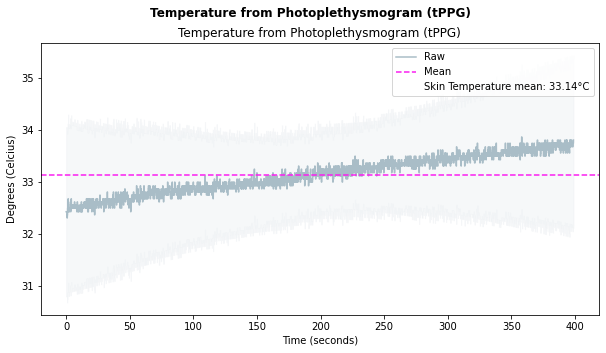

In [ ]:

plt.rcParams['figure.figsize'] = [10, 5]
path = '/content/drive/MyDrive/YOURPATH/SignalValidation/Figures/'
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'galea_temperature.eps'
fig = temp_plot(temp_processed[100:], 50)
fig.savefig(path+image_name, format=image_format, dpi=1200)

In [ ]:
y_err = x_axis.std() * np.sqrt(1/len(x_axis) + (x_axis - x_axis.mean())**2 / np.sum((x_axis - x_axis.mean())**2))
ax1.plot(x_axis, temp_signals["Temp_Raw"], color="#FB661C", label="Rate", linewidth=1.5)
ax1.fill_between(x_axis, temp_signals["Temp_Raw"] - y_err, temp_signals["Temp_Raw"] + y_err, alpha=0.2)


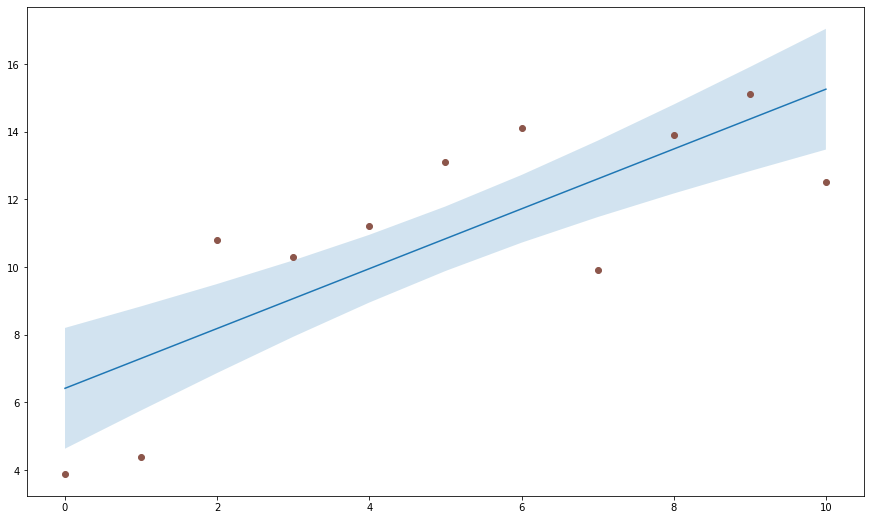

In [ ]:
N = 21
x = np.linspace(0, 10, 11)
y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

# fit a linear curve an estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(x, y, 'o', color='tab:brown')